In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
import scipy.spatial.distance
from scipy.special import erf
import math


In [2]:
# Define the sensor files and columns
sensor_files = {
    'accelerometer': 'Combined_Accelerometer_0.25s.csv',
    'gyroscope': 'Combined_Gyroscope_0.25s.csv',
    'linear_accelerometer': 'Combined_Linear Accelerometer_0.25s.csv',
    'magnetometer': 'Combined_Magnetometer_0.25s.csv'
}

sensor_columns = {
    'accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'gyroscope': ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)'],
    'linear_accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'magnetometer': ['X (µT)', 'Y (µT)', 'Z (µT)']
}

# Define the base path
base_path = '/Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Combined Data'


In [3]:
# Implements the Kalman filter for single columns.
class KalmanFilters:
    def apply_kalman_filter(self, data_table, col):
        kf = KalmanFilter(transition_matrices=[[1]], observation_matrices=[[1]])
        numpy_array_state = data_table[col].values
        numpy_array_state = numpy_array_state.astype(np.float32)
        numpy_matrix_state_with_mask = np.ma.masked_invalid(numpy_array_state)
        kf = kf.em(numpy_matrix_state_with_mask, n_iter=10)
        (new_data, filtered_state_covariances) = kf.filter(numpy_matrix_state_with_mask)
        data_table[col + '_kalman'] = new_data
        return data_table


In [4]:
# Utility function to normalize dataset
def normalize_dataset(data, cols):
    for col in cols:
        data[col] = (data[col] - data[col].mean()) / data[col].std()
    return data

# Function to detect outliers using Local Outlier Factor (LOF)
def detect_outliers_lof(data_table, cols, d_function='euclidean', k=5):
    new_data_table = normalize_dataset(data_table.dropna(axis=0, subset=cols), cols)
    lof = LocalOutlierFactor(n_neighbors=k, metric=d_function)
    for col in cols:
        df_col = new_data_table[col].values.reshape(-1, 1)
        outlier_flags = lof.fit_predict(df_col)
        print(f"LOF outlier flags for {col}: {np.unique(outlier_flags, return_counts=True)}")  # Debugging output
        data_table[col + '_lof'] = np.where(outlier_flags == -1, np.nan, data_table[col])
    return data_table


In [5]:
# Load the dataset
def load_data(filename):
    file_path = os.path.join(base_path, filename)
    return pd.read_csv(file_path)

def calculate_changes(data, original_col, filtered_col):
    diff = data[filtered_col].isna() | (np.abs(data[original_col] - data[filtered_col]) > 0)
    num_changes = diff.sum()
    perc_changes = (num_changes / len(data) * 100).round(2)
    return num_changes, perc_changes


In [6]:
def apply_kalman_and_compare(data, cols):
    kf_instance = KalmanFilters()
    summary_results = []

    for col in cols:
        # Apply Kalman filter
        data = kf_instance.apply_kalman_filter(data, col)
        num_changes_kalman, perc_changes_kalman = calculate_changes(data, col, col + '_kalman')

        summary_results.append({
            'Sensor Type': col,
            'Kalman_Num_Changes': num_changes_kalman,
            'Kalman_Perc_Changes': perc_changes_kalman,
        })

        # Plot original vs Kalman filtered data
        plt.figure(figsize=(10, 6))
        plt.plot(data['time'], data[col], label='Original')
        plt.plot(data['time'], data[col + '_kalman'], label='Kalman Filtered')
        plt.title(f'{col} - Original vs Kalman Filtered')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()

    return pd.DataFrame(summary_results)


In [7]:
def apply_lof_and_compare(data, cols):
    summary_results = []

    # Apply LOF
    data = detect_outliers_lof(data, cols)
    for col in cols:
        num_changes_lof, perc_changes_lof = calculate_changes(data, col, col + '_lof')

        summary_results.append({
            'Sensor Type': col,
            'LOF_Num_Changes': num_changes_lof,
            'LOF_Perc_Changes': perc_changes_lof,
        })

        # Plot original vs LOF data
        plt.figure(figsize=(10, 6))
        plt.plot(data['time'], data[col], label='Original')
        plt.plot(data['time'], data[col + '_lof'], label='LOF Filtered', linestyle='None', marker='o')
        plt.title(f'{col} - Original vs LOF Filtered')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()

    return pd.DataFrame(summary_results)


Initial statistics for accelerometer from Combined_Accelerometer_0.25s.csv:
         X (m/s^2)    Y (m/s^2)    Z (m/s^2)
count  1203.000000  1203.000000  1203.000000
mean     -1.453352    -0.510362     2.246457
std      11.721227     5.186409     3.974443
min     -29.228681   -21.215065    -9.630721
25%     -11.678108    -3.394180    -0.552744
50%      -1.295586     0.300671     2.121233
75%       9.191564     2.847418     4.838661
max      30.706994    10.407228    13.981417


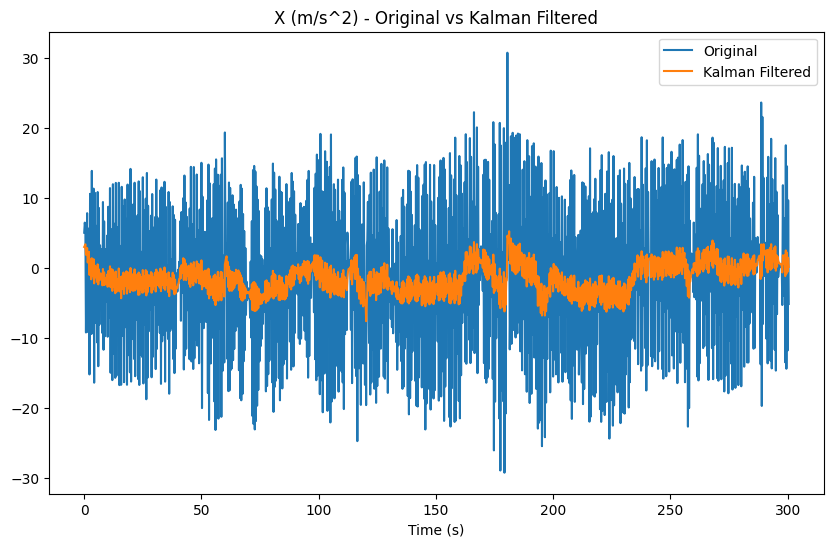

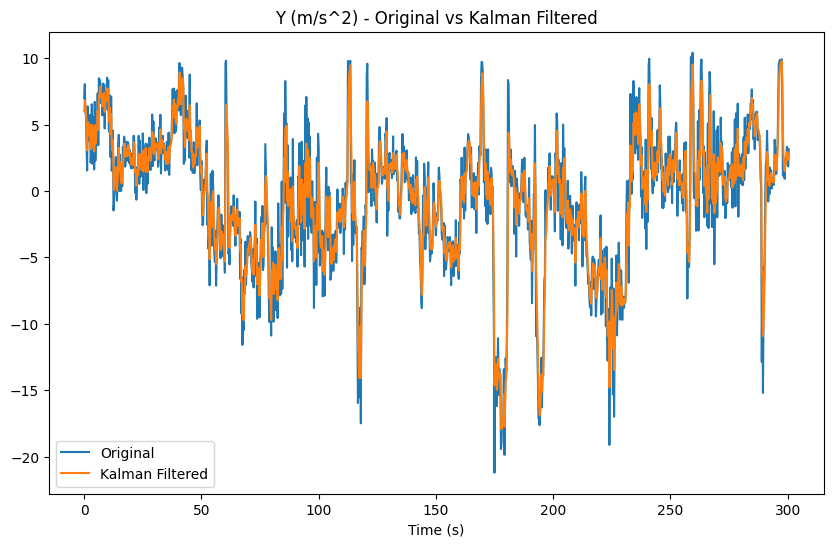

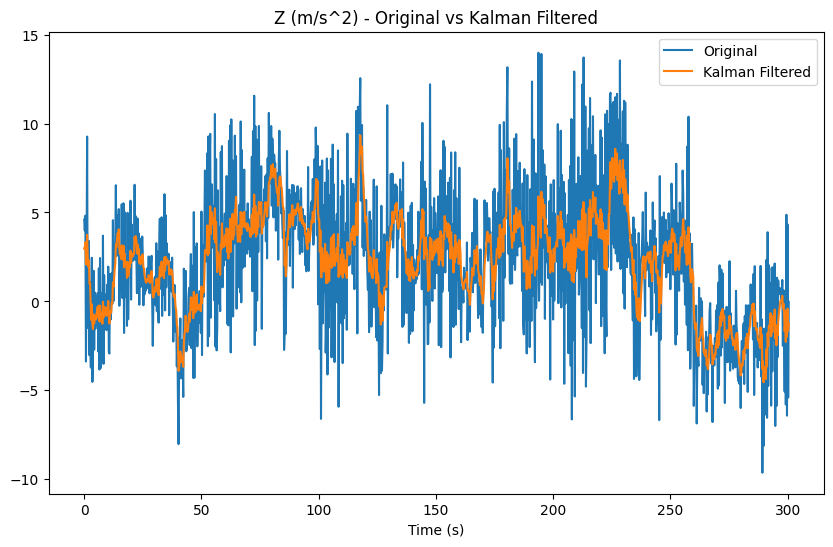

LOF outlier flags for X (m/s^2): (array([-1,  1]), array([  85, 1118]))
LOF outlier flags for Y (m/s^2): (array([-1,  1]), array([  65, 1138]))
LOF outlier flags for Z (m/s^2): (array([-1,  1]), array([  76, 1127]))


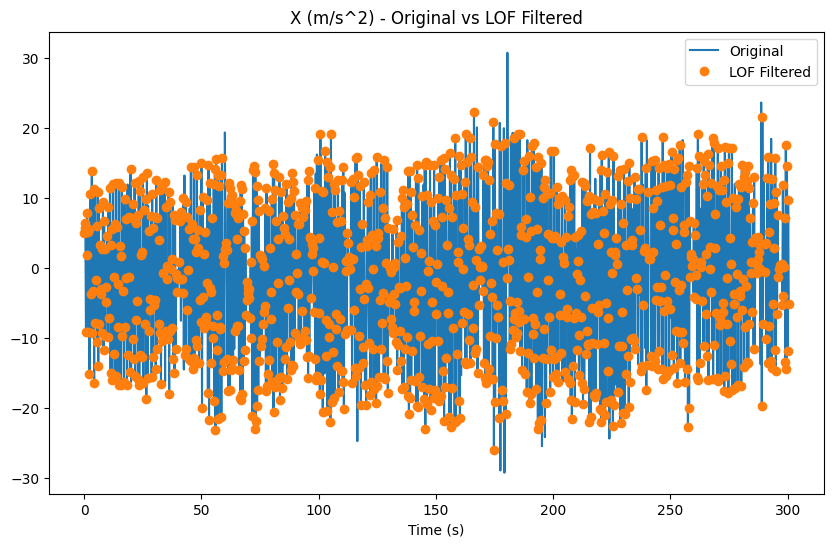

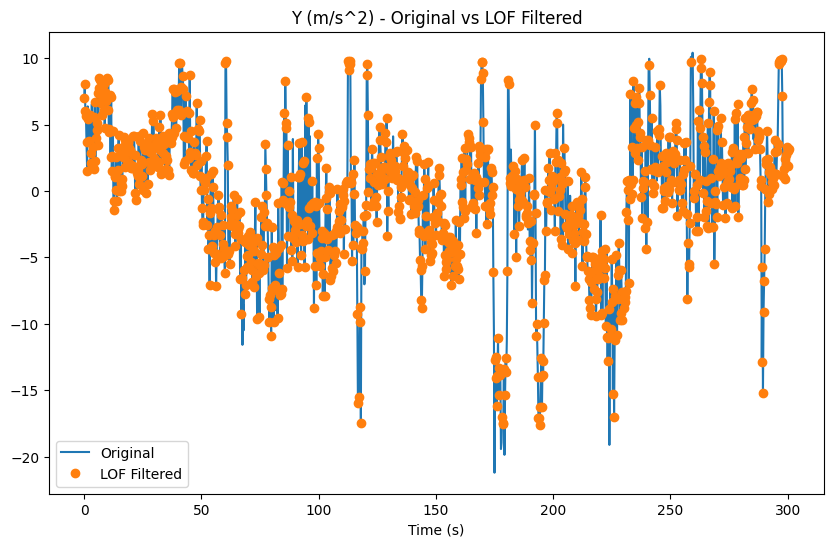

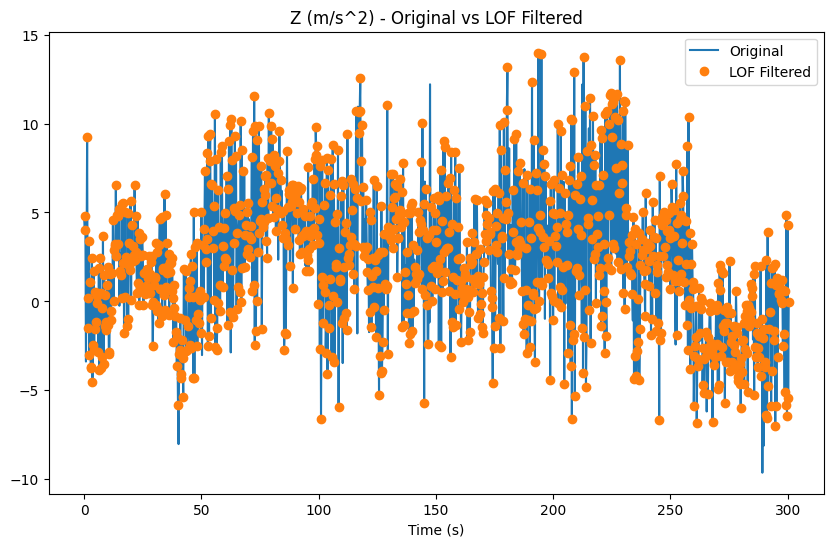

Initial statistics for gyroscope from Combined_Gyroscope_0.25s.csv:
         X (rad/s)    Y (rad/s)    Z (rad/s)
count  1201.000000  1201.000000  1201.000000
mean      0.280012    -0.036217     0.066631
std       1.184879     1.161952     4.110825
min      -3.271785    -5.203266   -10.182575
25%      -0.492632    -0.784451    -3.512119
50%       0.196221    -0.042392    -0.061055
75%       0.984997     0.666574     3.778822
max       4.063844     6.355003    10.325570


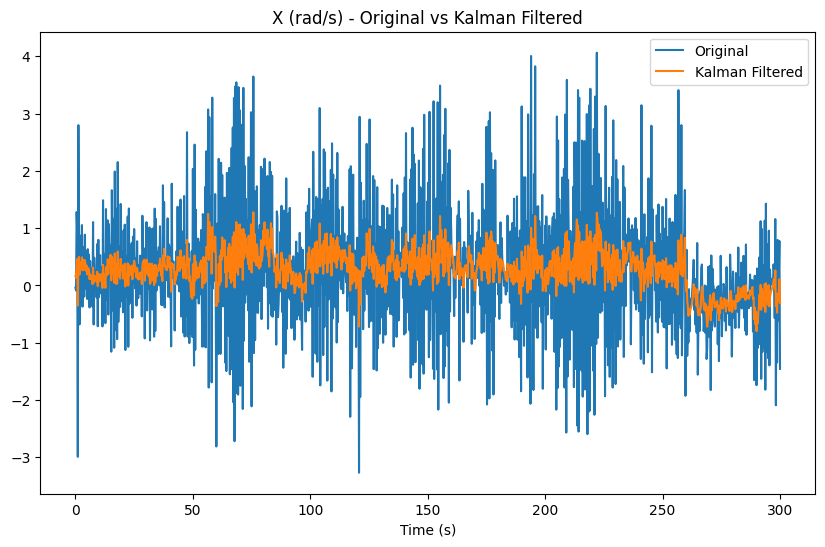

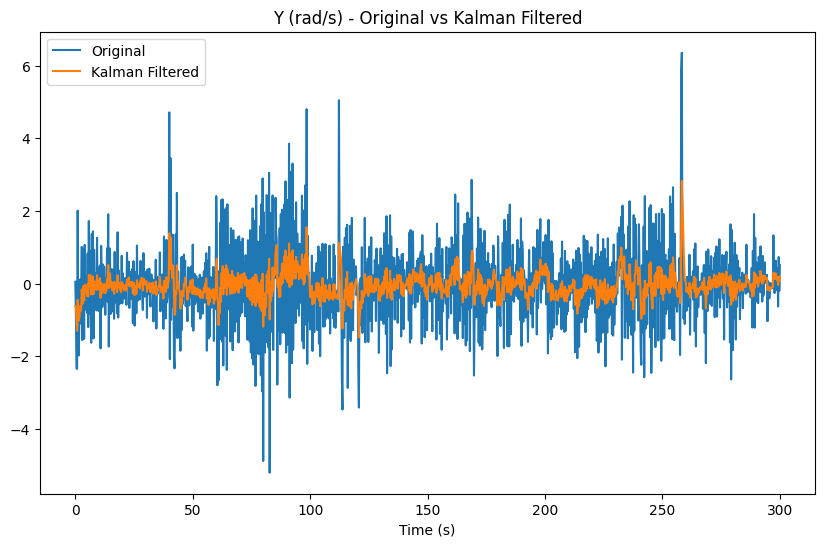

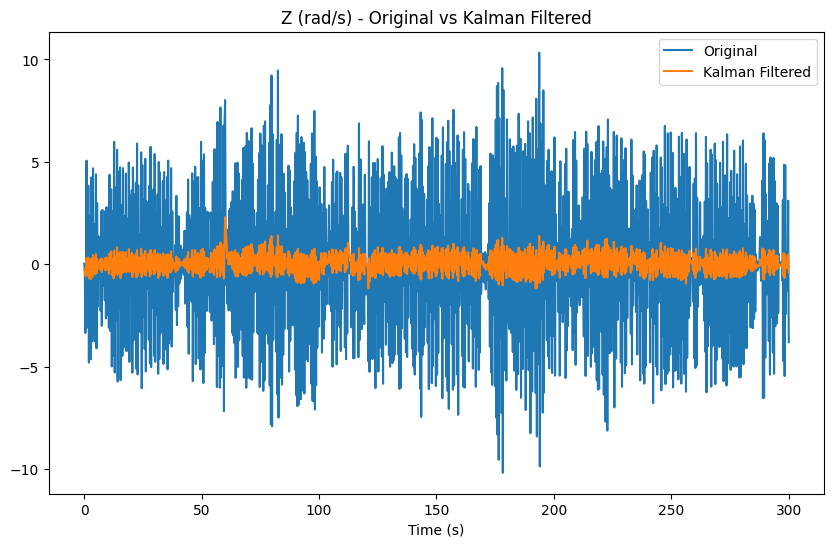

LOF outlier flags for X (rad/s): (array([-1,  1]), array([  73, 1128]))
LOF outlier flags for Y (rad/s): (array([-1,  1]), array([  55, 1146]))
LOF outlier flags for Z (rad/s): (array([-1,  1]), array([  69, 1132]))


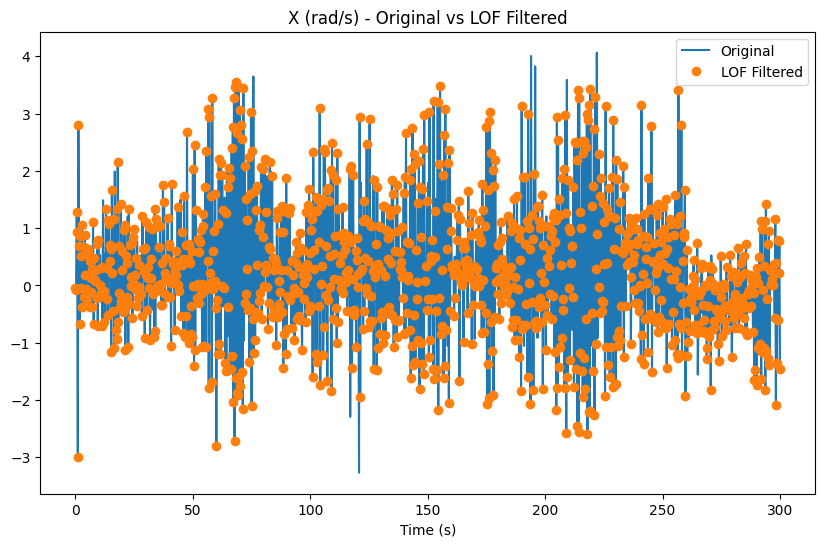

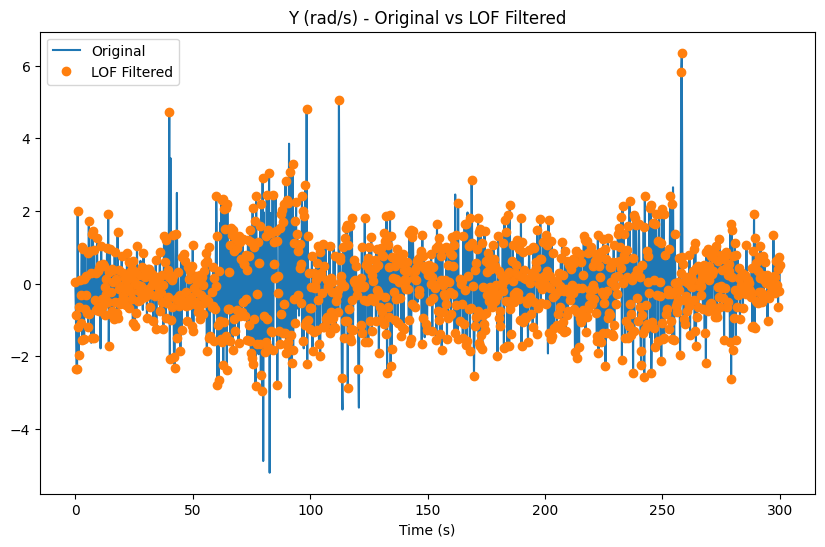

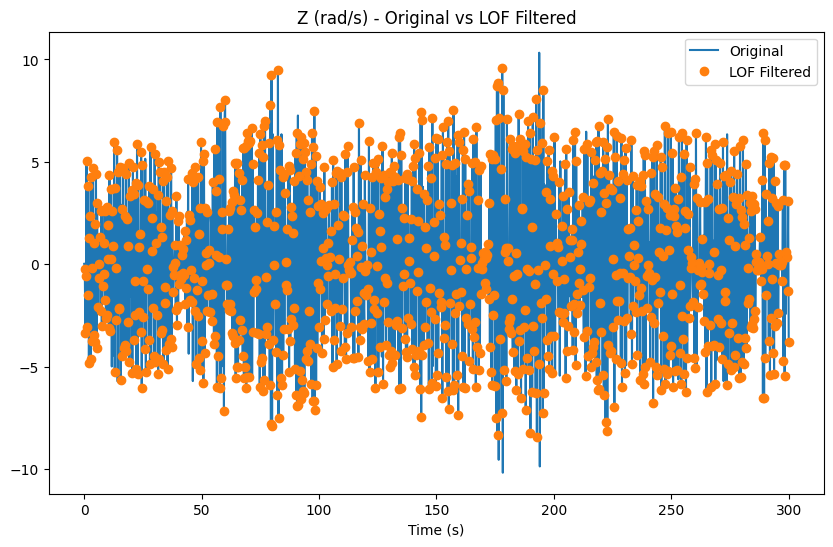

Initial statistics for linear_accelerometer from Combined_Linear Accelerometer_0.25s.csv:
         X (m/s^2)    Y (m/s^2)    Z (m/s^2)
count  1201.000000  1201.000000  1201.000000
mean      0.430826    -8.289827     0.741224
std       8.755658     4.303773     2.649394
min     -20.563647   -27.671566    -7.981358
25%      -7.492558   -10.637881    -1.011248
50%       0.107773    -7.724764     0.613579
75%       8.679530    -5.517039     2.480915
max      20.073416     1.254962     9.165926


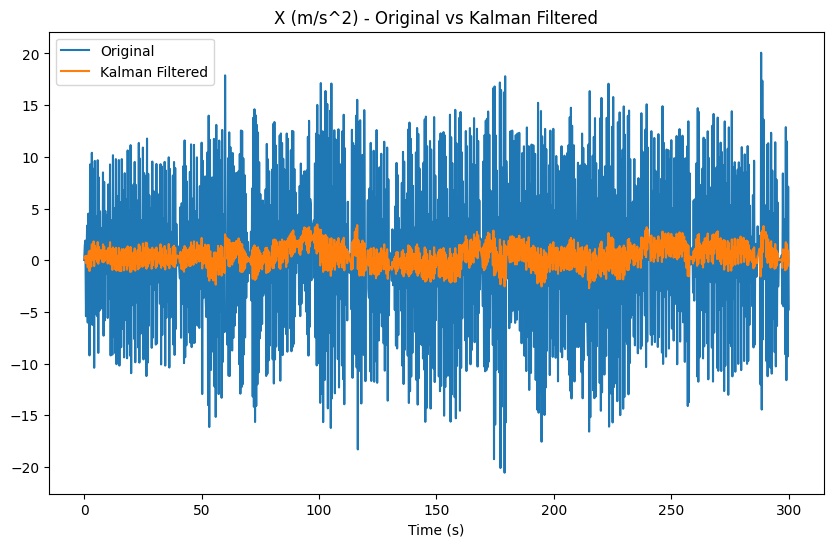

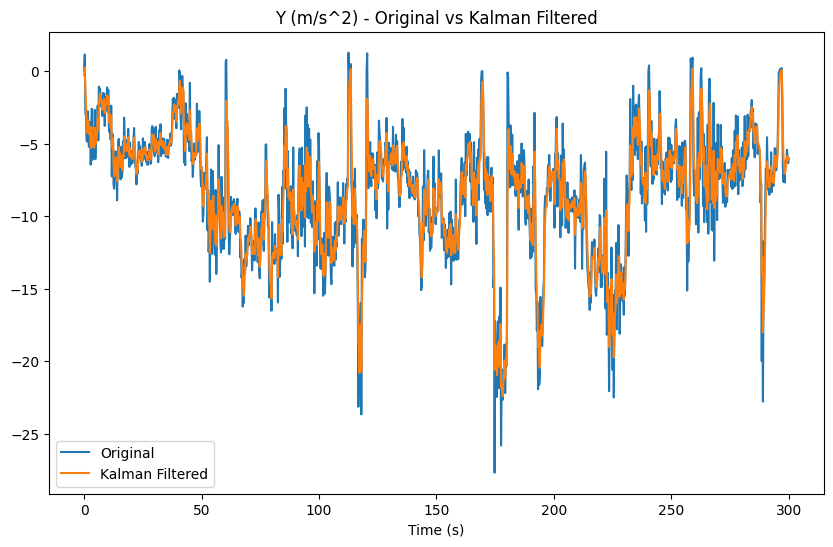

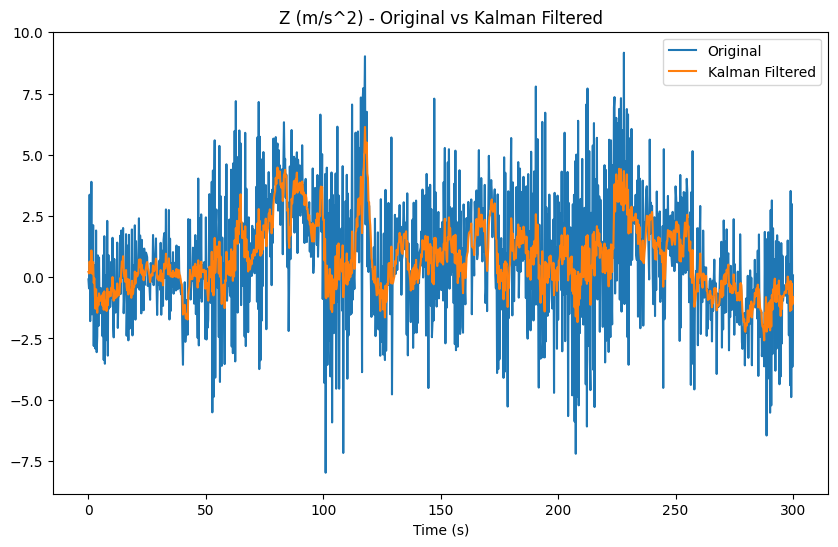

LOF outlier flags for X (m/s^2): (array([-1,  1]), array([  77, 1124]))
LOF outlier flags for Y (m/s^2): (array([-1,  1]), array([  54, 1147]))
LOF outlier flags for Z (m/s^2): (array([-1,  1]), array([  50, 1151]))


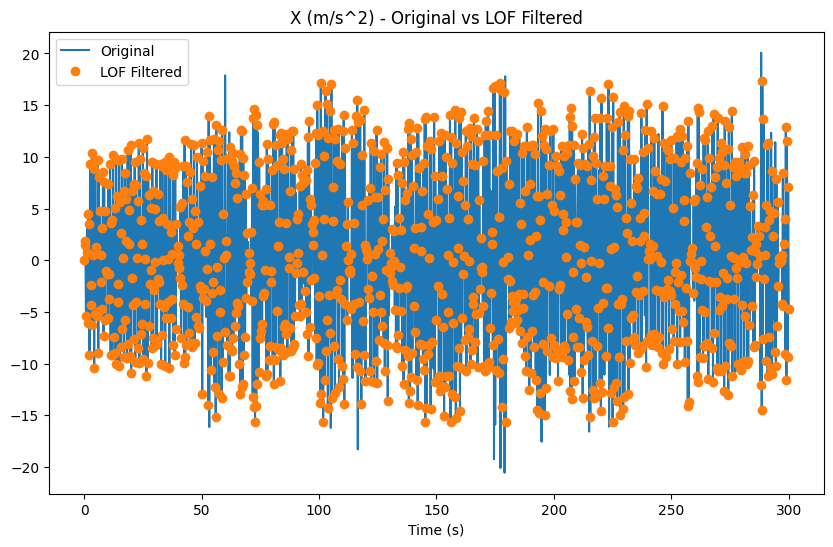

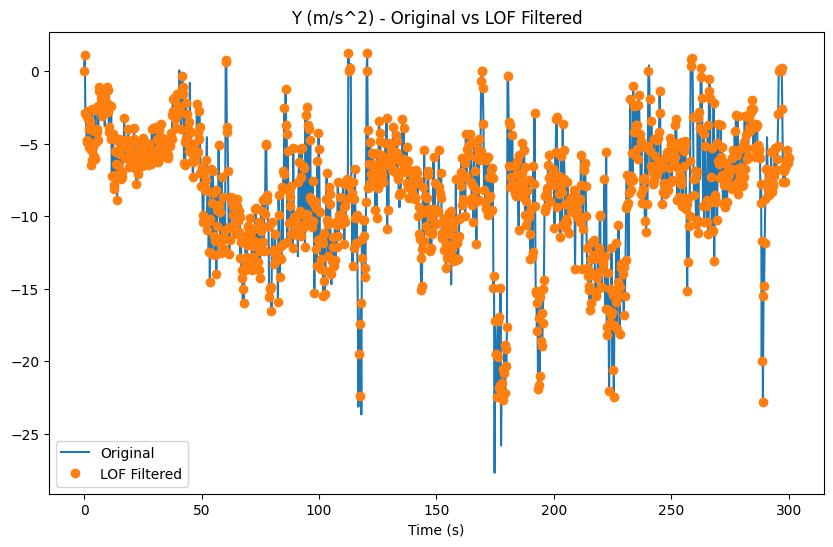

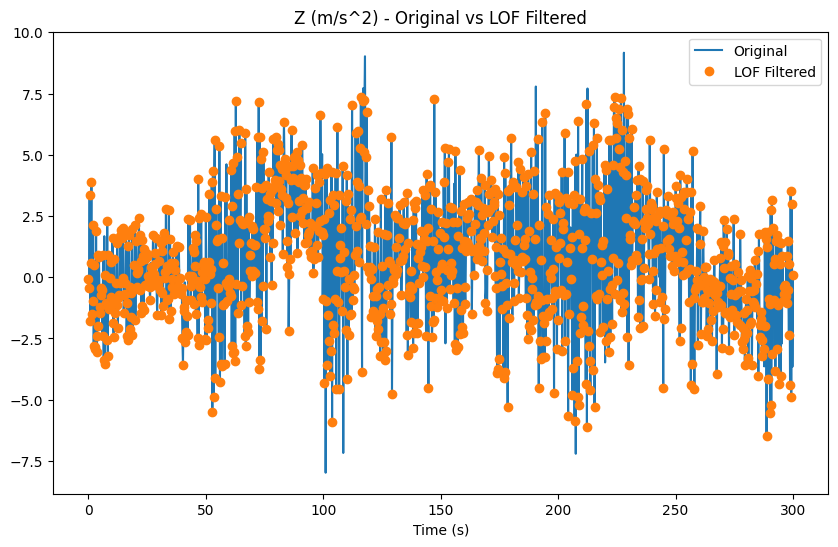

Initial statistics for magnetometer from Combined_Magnetometer_0.25s.csv:
            X (µT)       Y (µT)       Z (µT)
count  1201.000000  1201.000000  1201.000000
mean     61.218530  -176.174429    94.417375
std     102.770869   334.680363   228.308152
min     -34.068956  -929.616967   -32.837623
25%      11.216352   -35.274569   -19.721357
50%      22.775408   -28.165685    -8.443002
75%      32.849509   -21.713684    19.283893
max     305.043143    11.782269   631.872615


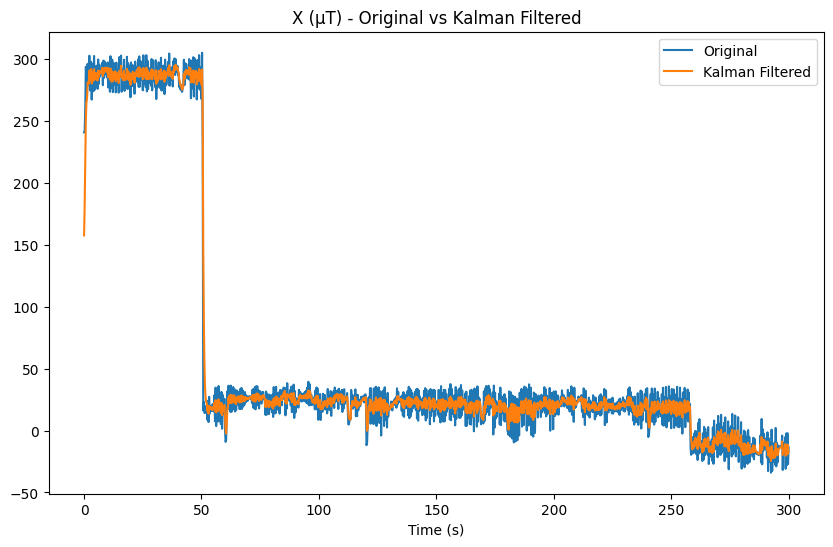

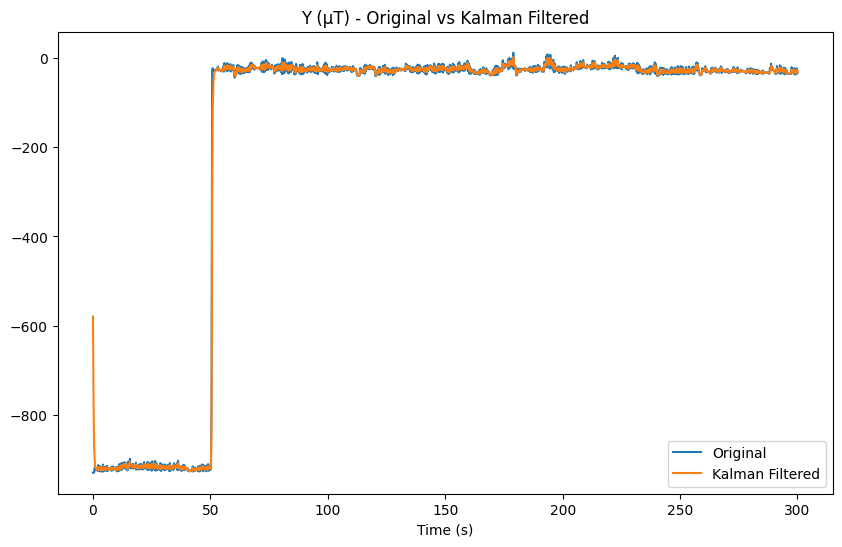

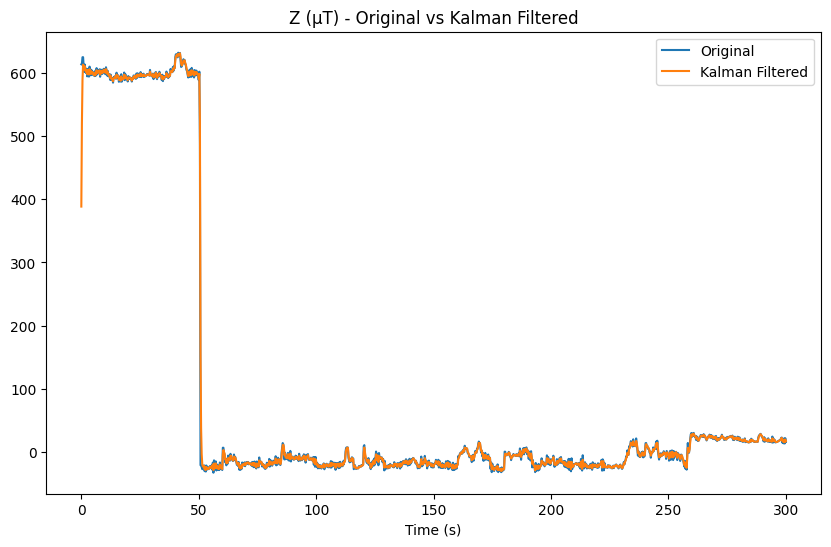

LOF outlier flags for X (µT): (array([-1,  1]), array([  71, 1130]))
LOF outlier flags for Y (µT): (array([-1,  1]), array([  68, 1133]))
LOF outlier flags for Z (µT): (array([-1,  1]), array([  74, 1127]))


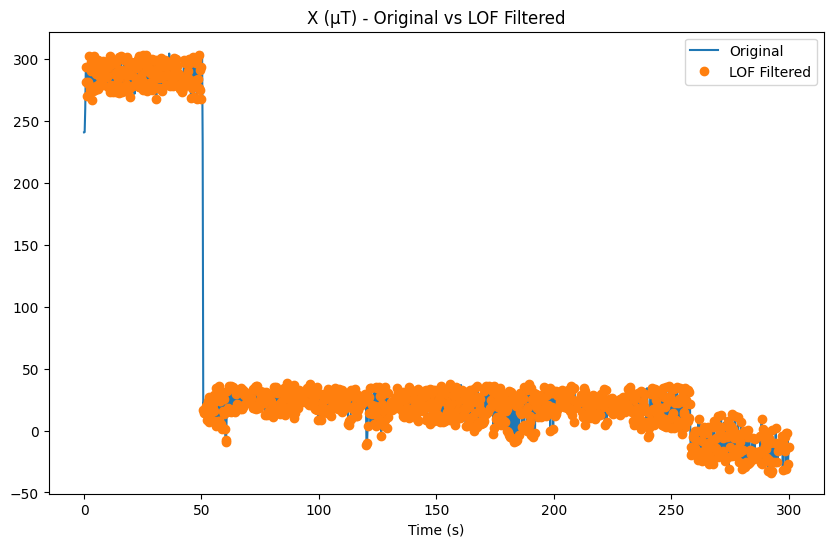

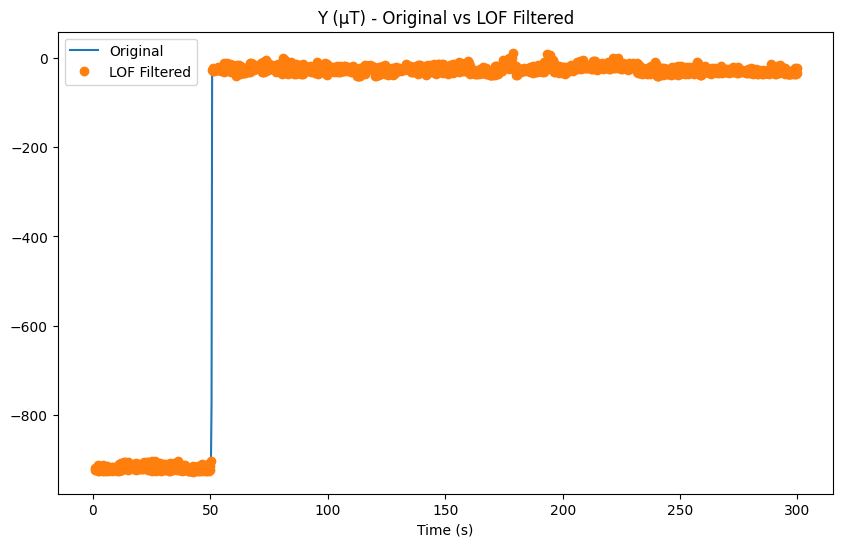

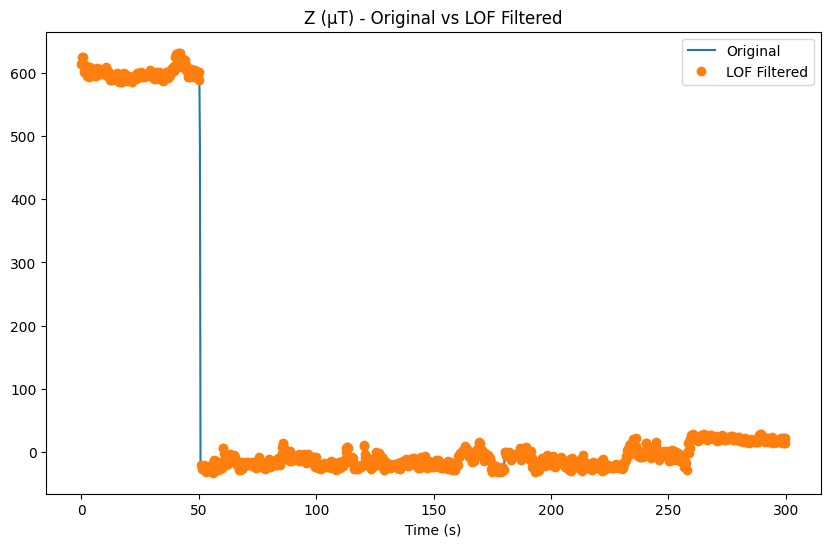

In [8]:
# Perform comparison on each combined file
kalman_summary_all = []
lof_summary_all = []

for sensor_type, filename in sensor_files.items():
    cols = sensor_columns[sensor_type]
    data = load_data(filename)
    
    # Initial data statistics
    print(f"Initial statistics for {sensor_type} from {filename}:")
    print(data[cols].describe())
    
    # Apply Kalman filter and compare
    kalman_summary = apply_kalman_and_compare(data.copy(), cols)
    kalman_summary['File'] = filename
    kalman_summary_all.append(kalman_summary)
    
    # Apply LOF and compare
    lof_summary = apply_lof_and_compare(data.copy(), cols)
    lof_summary['File'] = filename
    lof_summary_all.append(lof_summary)

# Concatenate all summaries
final_kalman_summary = pd.concat(kalman_summary_all, ignore_index=True)
final_lof_summary = pd.concat(lof_summary_all, ignore_index=True)

# Save the summaries to CSV files
final_kalman_summary.to_csv(os.path.join(base_path, 'kalman_filter_comparison_summary.csv'), index=False)
final_lof_summary.to_csv(os.path.join(base_path, 'lof_filter_comparison_summary.csv'), index=False)


In [9]:
# Display the final summaries
print("Kalman Filter Summary:")
print(final_kalman_summary)
print("\nLOF Summary:")
print(final_lof_summary)

Kalman Filter Summary:
   Sensor Type  Kalman_Num_Changes  Kalman_Perc_Changes  \
0    X (m/s^2)                1203                100.0   
1    Y (m/s^2)                1203                100.0   
2    Z (m/s^2)                1203                100.0   
3    X (rad/s)                1201                100.0   
4    Y (rad/s)                1201                100.0   
5    Z (rad/s)                1201                100.0   
6    X (m/s^2)                1201                100.0   
7    Y (m/s^2)                1201                100.0   
8    Z (m/s^2)                1201                100.0   
9       X (µT)                1201                100.0   
10      Y (µT)                1201                100.0   
11      Z (µT)                1201                100.0   

                                       File  
0          Combined_Accelerometer_0.25s.csv  
1          Combined_Accelerometer_0.25s.csv  
2          Combined_Accelerometer_0.25s.csv  
3              Combined_G